# Preparation des données
### Initialisation du projet

In [3]:
# imports
import numpy as np
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(420) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "projet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img") # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Importation

In [4]:
import os
import pandas as pd

DATASETS_PATH = os.path.join(".\datasets")

def load_datasets_data(dataset_path=DATASETS_PATH):
	csv_general = pd.read_csv(os.path.join(dataset_path, "general_data.csv"))
	csv_manager = pd.read_csv(os.path.join(dataset_path, "manager_survey_data.csv"))
	csv_employee = pd.read_csv(os.path.join(dataset_path, "employee_survey_data.csv"))
	csv_intime = pd.read_csv(os.path.join(dataset_path, "in_time.csv"))
	csv_outtime = pd.read_csv(os.path.join(dataset_path, "out_time.csv"))
	return csv_general, csv_manager, csv_employee, csv_intime, csv_outtime

In [5]:
general_set, manager_set, employee_set, intime_set, outtime_set = load_datasets_data()

In [6]:
pd.DataFrame.head(general_set, 5)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [7]:
dataset_merge = general_set.merge(employee_set.merge(manager_set, on="EmployeeID"), on="EmployeeID")
dataset = dataset_merge.copy()
pd.DataFrame.head(dataset, 5)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


<AxesSubplot:>

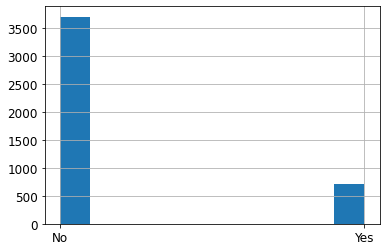

In [8]:
#Affichage du nb d'individus ayant quitté ou non l'entreprise
dataset["Attrition"].hist()

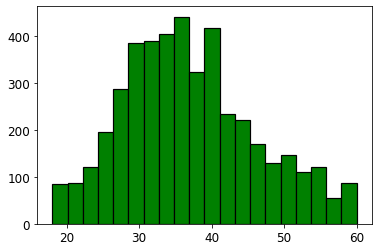

In [10]:
#Test histogramme sur l'age
plt.hist(dataset["Age"],color="green", edgecolor='black', linewidth=1.2,bins=20)
plt.show()

### Nettoyage des données / Complétion

In [12]:
#https://prod.liveshare.vsengsaas.visualstudio.com/join?6712A4B62ABC55A3AC374AFD25A834927C4D

incomplete_attributes = ["NumCompaniesWorked","JobSatisfaction","EnvironmentSatisfaction","WorkLifeBalance", "TotalWorkingYears"]

for attribute in incomplete_attributes:
	median = dataset[attribute].median()
	dataset[attribute].fillna(median, inplace=True) # option 3

#Autre methode
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.nan, strategy="median")

In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Attrition is NO:  3699  Attrition is YES:  711
Age


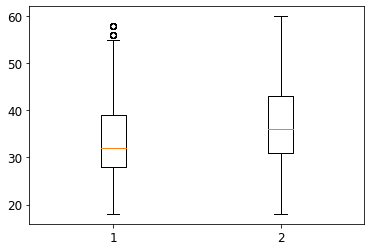

DistanceFromHome


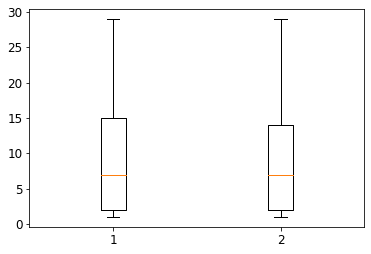

YearsAtCompany


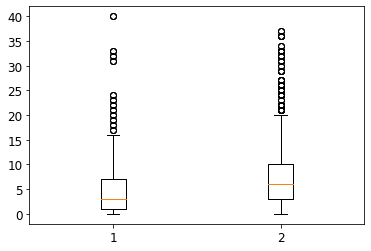

Education


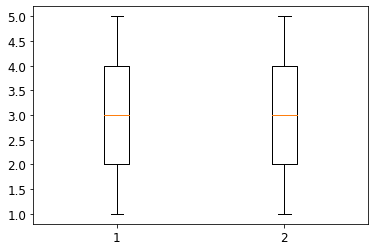

TotalWorkingYears


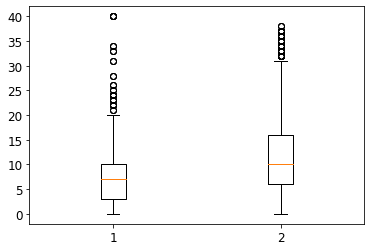

TrainingTimesLastYear


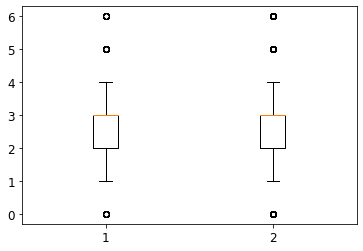

YearsAtCompany


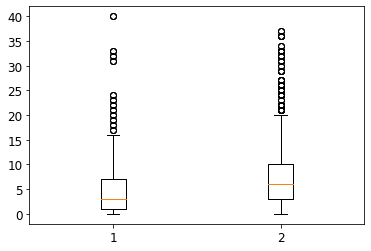

YearsSinceLastPromotion


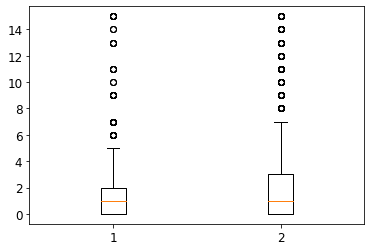

YearsWithCurrManager


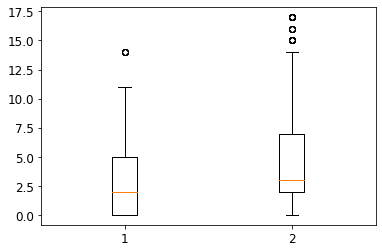

EnvironmentSatisfaction


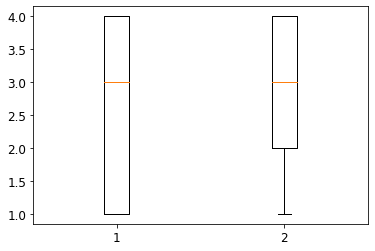

JobSatisfaction


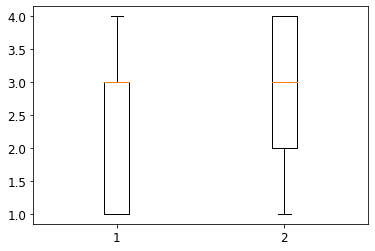

WorkLifeBalance


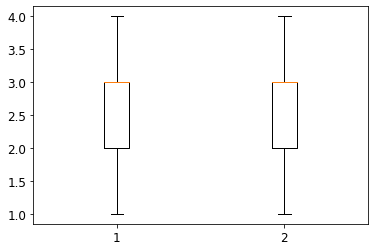

JobInvolvement


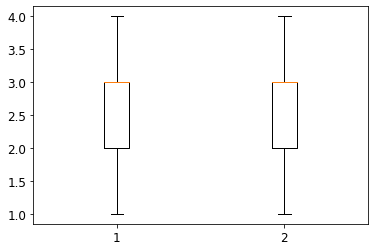

NumCompaniesWorked


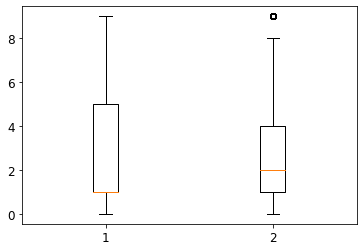

In [15]:
rawArray = ["Age","DistanceFromHome","YearsAtCompany","Education","TotalWorkingYears",
	"TrainingTimesLastYear","YearsAtCompany","YearsSinceLastPromotion","YearsWithCurrManager",
	"EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance","JobInvolvement", "NumCompaniesWorked" ]

dataset_yes = dataset.where(dataset["Attrition"]=="Yes", 0)
dataset_no  = dataset.where(dataset["Attrition"]=="No", 1)

dataset_yes = dataset_yes.loc[dataset_yes["Attrition"] != 0]
dataset_no = dataset_no.loc[dataset_no["Attrition"] != 1]

print("Attrition is NO: " , len(dataset_no) ," Attrition is YES: " , len(dataset_yes))


for col in rawArray:
    plt.boxplot([dataset_yes[col].apply(np.int64), dataset_no[col].apply(np.int64)])
    print(col)
    plt.show()